# Calculation of Mortality Rate – Demographic Flow Method  
*(Argentina example — reverse-engineering deaths from population balances)*

## 1. Core idea
Population changes from births, migration and deaths:

$$
P_{t+1} = P_t + \text{Births}_t + \text{Immigration}_t - \text{Emigration}_t - \text{Deaths}_t
$$

## 2. Solve for deaths
Rearrange to estimate deaths:

$$
\text{Deaths}_t = P_t + \text{Births}_t + \text{Immigration}_t - \text{Emigration}_t - P_{t+1}
$$

(Plug observed P, births and migration for the year t.)

## 3. Why it works for Argentina (brief)
- INDEC publishes annual population and births.  
- Migration estimates + population totals let you back-calculate deaths even when death registration is delayed.

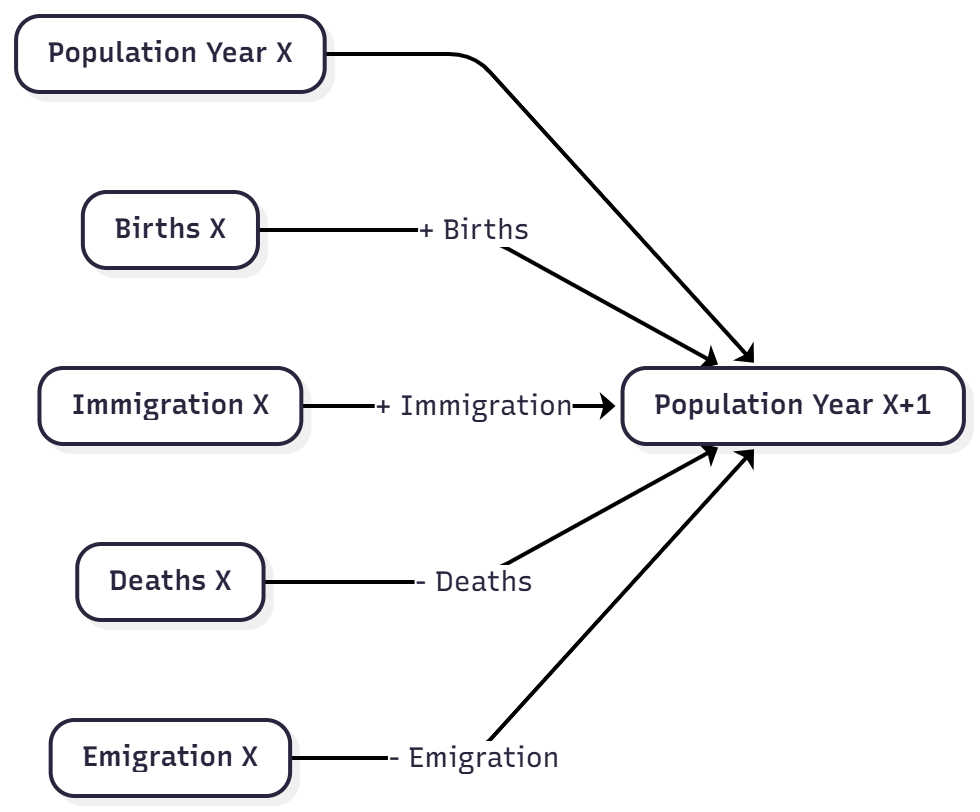


## Data Preparation

To begin the analysis, we first load and preprocess the raw datasets so they fit the structure required for the demographic model.

---

### 1. Births (2005–2023)

- Import the births dataset.
- Filter the years relevant for the study (2019–2023).
- Sort the data by year and reset the index.
- Preview the cleaned dataset using `births.tail()`.

---

### 2. Population (2005–2024)

- Load the official annual population dataset.
- Keep only data from 2019 onward.
- Sort the records in chronological order.
- Reset the index to maintain consistency across datasets.

---

### 3. Migrations (2019–2024)

- Import the migration dataset containing annual entries and exits.
- Clean and normalize the column names to avoid formatting inconsistencies.

---

### 4. Data Unification

To perform the mortality calculation using the demographic flow method, we must consolidate the isolated datasets into a single analytical dataframe. 

We will merge the **Population**, **Births**, and **Migrations** dataframes using the `YEAR` column as the common key.

The final unified dataset will contain the following components for each year (2019–2023):

* **YEAR**: The reference time period.
* **POPULATION**: Total population estimate for the specific year ($P_t$).
* **BIRTHS**: Total live births registered ($B_t$).
* **IMMIGRATION**: Total entries into the country ($I_t$).
* **EMIGRATION**: Total exits from the country ($E_t$).
* **TOTAL_MIGRATION**: The sum of all movement (Entries + Exits), mostly for validation purposes.

Once merged, we will be able to apply the formula:
$$D_t = P_t + B_t + (I_t - E_t) - P_{t+1}$$

### 1. Births (2005–2023)

- Import the births dataset.
- Filter the years relevant for the study (2019–2023).
- Sort the data by year and reset the index.
- Preview the cleaned dataset using `births.tail()`.

In [ ]:
import csv
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('dataset/nacimientos-2005-2023.xlsx', engine='openpyxl')

In [ ]:
# We filter our desired year (2019-2023); we sort by Year; we reset indexes; We rename columns; We drop unnecesary column
births = df.loc[df['AÑO'] > 2018].sort_values(by='AÑO', ascending=True).reset_index(drop=True)
births = births.rename(columns={'AÑO': 'YEAR', 'NACIDOS_VIVOS_REGISTRADOS': 'BIRTHS'}).drop(['AREA'], axis = 1)

In [ ]:
births.tail()

,YEAR,BIRTHS
0,2019,625441
1,2020,533299
2,2021,529794
3,2022,495295
4,2023,460902


---

### 2. Population (2005–2024)

- Load the official annual population dataset.
- Keep only data from 2019 onward.
- Sort the records in chronological order.
- Reset the index to maintain consistency across datasets.

In [ ]:
df = pd.read_csv('dataset/poblacion-argentina-2005-2024.csv')

In [ ]:
population = df.loc[df['Year'] > 2018].sort_values(by='Year', ascending=True).reset_index(drop=True)
population.rename(columns={'Year': 'YEAR', 'Total': 'POPULATION'})

,YEAR,POPULATION
0,2019,44973465
1,2020,45191965
2,2021,45312281
3,2022,45407904
4,2023,45538401
5,2024,45696159


---

### 3. Migrations (2019–2024)

- Import the migration dataset containing annual entries and exits.
- Clean and normalize the column names to avoid formatting inconsistencies.

In [ ]:
df_2 = pd.read_csv('dataset/migraciones-2019-2024.csv')
df_2.head()

,ANIO,ENTRADAS,SALIDAS,TOTAL
0,2019,34.413.753,34.522.066,68.935.819
1,2020,9.705.757,9.541.981,19.247.738
2,2021,3.110.402,3.347.356,6.457.758
3,2022,24.036.545,23.911.744,47.948.289
4,2023,37.118.359,36.522.139,73.640.498


In [ ]:
df_2.columns = df_2.columns.str.strip()
migrations = df_2.rename(columns={
    'ANIO': 'YEAR',
    'ENTRADAS': 'IMMIGRATION',
    'SALIDAS': 'EMIGRATION',
    'TOTAL': 'TOTAL_MIGRATION'
})

migrations.head()


,YEAR,IMMIGRATION,EMIGRATION,TOTAL_MIGRATION
0,2019,34.413.753,34.522.066,68.935.819
1,2020,9.705.757,9.541.981,19.247.738
2,2021,3.110.402,3.347.356,6.457.758
3,2022,24.036.545,23.911.744,47.948.289
4,2023,37.118.359,36.522.139,73.640.498
